In [ ]:
import pytplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# from .slice2d_getinfo import slice2d_getinfo  # Certifique-se de que essa função esteja disponível

def slice2d_plot_mod(
    the_slice,
    xrange=None,
    yrange=None,
    zrange=None,
    colormap=None,
    olines=8,
    contours=False,
    plotsize=10,
    title=None,
    save_png=None,
    save_jpeg=None,
    save_svg=None,
    save_pdf=None,
    save_eps=None,
    dpi=None,
    display=True,
):
    """
    Cria gráficos de cortes 2D da distribuição de partículas com filtro para remover
    velocidades com módulo menor que 2000 km/s (ou unidade equivalente), criando um "buraco"
    branco no centro do gráfico.
    """
    spec_options = {}

    if zrange is None:
        zrange = the_slice.get("zrange")
        if zrange is not None:
            zrange = [zrange[0] * 0.999, zrange[1] * 1.001]

    if zrange is None:
        spec_options["norm"] = mpl.colors.LogNorm()
    else:
        spec_options["norm"] = mpl.colors.LogNorm(vmin=zrange[0], vmax=zrange[1])

    style = pytplot.tplot_opt_glob.get("style")
    if style is None:
        if colormap is None:
            colormap = "spedas"
    else:
        plt.style.use(style)

    if colormap == "spedas":
        _colors = pytplot.spedas_colorbar
        spd_map = [
            (np.array([r, g, b])).astype(np.float64) / 256
            for r, g, b in zip(_colors.r, _colors.g, _colors.b)
        ]
        cmap = LinearSegmentedColormap.from_list("spedas", spd_map)
    else:
        cmap = colormap

    spec_options["cmap"] = cmap

    char_size = pytplot.tplot_opt_glob.get("charsize")
    if char_size is None:
        char_size = 12

    fig, axes = plt.subplots()
    fig.set_size_inches(plotsize, plotsize)

    if xrange is not None:
        axes.set_xlim(xrange)
    if yrange is not None:
        axes.set_ylim(yrange)

    axis_font_size = pytplot.tplot_opt_glob.get("axis_font_size")
    if axis_font_size is not None:
        axes.tick_params(axis="x", labelsize=axis_font_size)
        axes.tick_params(axis="y", labelsize=axis_font_size)

    info = slice2d_getinfo(the_slice, title=title)

    axes.set_title(info["title"], fontsize=char_size)
    axes.set_ylabel(info["ytitle"], fontsize=char_size)
    axes.set_xlabel(info["xtitle"], fontsize=char_size)

    fig.subplots_adjust(left=0.14, right=0.86, top=0.86, bottom=0.14)

    box = axes.get_position()
    pad, width = 0.02, 0.01
    cax = fig.add_axes([box.xmax + pad, box.ymin, width, box.height])

    if axis_font_size is not None:
        cax.tick_params(labelsize=axis_font_size)

    # >>>> FILTRO PARA REMOVER BAIXAS VELOCIDADES <<<<
    x = the_slice["x"]
    y = the_slice["y"]
    z = np.array(the_slice["z"])  # Garantia de tipo

    if x.ndim == 1 and y.ndim == 1:
        X, Y = np.meshgrid(x, y)
    else:
        X, Y = x, y

    radius = np.sqrt(X**2 + Y**2)
    mask = radius < 2000  # RAIO DO BURACO (em unidade de velocidade)
    z_masked = np.where(mask, np.nan, z)

    the_slice["z"] = z_masked

    # >>>> PLOT PRINCIPAL <<<<
    im = axes.pcolormesh(X, Y, z_masked, shading='auto', **spec_options)
    colorbar = fig.colorbar(im, cax=cax)
    colorbar.set_label(info["ztitle"], fontsize=char_size)

    # Linhas no centro
    axes.axvline(x=0, linestyle=(0, (5, 10)), color="black")
    axes.axhline(y=0, linestyle=(0, (5, 10)), color="black")

    interp_type = the_slice.get("interpolation")
    if interp_type != "geometric" or contours:
        levels = 10.0 ** (
            np.arange(olines)
            / float(olines)
            * (np.log10(zrange[1]) - np.log10(zrange[0]))
            + np.log10(zrange[0])
        )
        contours = axes.contour(
            the_slice["xgrid"],
            the_slice["ygrid"],
            the_slice["data"].T,
            levels,
            linewidths=0.5,
        )

    # >>>> SALVAMENTO <<<<
    if save_png:
        if not save_png.endswith(".png"):
            save_png += ".png"
        plt.savefig(save_png, dpi=dpi)

    if save_jpeg:
        if not save_jpeg.endswith(".jpeg"):
            save_jpeg += ".jpeg"
        plt.savefig(save_jpeg, dpi=dpi)

    if save_eps:
        if not save_eps.endswith(".eps"):
            save_eps += ".eps"
        plt.savefig(save_eps, dpi=dpi)

    if save_svg:
        if not save_svg.endswith(".svg"):
            save_svg += ".svg"
        plt.savefig(save_svg, dpi=dpi)

    if save_pdf:
        if not save_pdf.endswith(".pdf"):
            save_pdf += ".pdf"
        plt.savefig(save_pdf, dpi=dpi)

    if display:
        plt.show()


In [ ]:
import logging
import pyspedas
from pytplot import time_double
#from pyspedas.projects.mms.fpi_tools.mms_get_fpi_dist import mms_get_fpi_dist
#from pyspedas.projects.mms.hpca_tools.mms_get_hpca_dist import mms_get_hpca_dist
from pyspedas.particles.spd_slice2d.slice2d import slice2d
from pyspedas.particles.spd_slice2d.slice2d_plot import slice2d_plot


def mms_part_slice2d_mod(trange=None,
                     time=None,
                     samples=None,
                     window=None,
                     center_time=False,
                     erange=None,
                     thetarange=None,
                     zdirrange=None,
                     average_angle=None,
                     sum_angle=None,
                     energy=False,
                     log=False,
                     probe='1',
                     instrument='fpi',
                     data_rate=None,
                     level='l2',
                     spdf=False,
                     mag_data_rate=None,
                     species=None,
                     rotation='xy',
                     custom_rotation=None,
                     slice_x=None,
                     slice_norm=None,
                     subtract_bulk=False,
                     xrange=None,
                     yrange=None,
                     zrange=None,
                     resolution=None,
                     interpolation='geometric',
                     contours=False,
                     title=None,
                     smooth=None,
                     save_jpeg=None,
                     save_png=None,
                     save_svg=None,
                     save_pdf=None,
                     save_eps=None,
                     plotsize=10,
                     dpi=None,
                     return_slice=False,
                     cmap=None,
                     display=True):
    """
    This routine creates 2D slices of 3D distribution function data from the FPI and HPCA instruments.
    This is essentially a wrapper around slice2d and slice2d_plot, that loads the data,
    any required support data, calculates the slice with slice2d and plots it with slice2d_plot.

    Parameters
    -----------
        probe: int or str
            MMS spacecraft probe # (1, 2, 3 or 4)

        instrument: str
            MMS plasma instrument (fpi or hpca)

        species: str
            Particle species; depends on the instrument::

                FPI: 'e' for electrons, 'i' for ions
                HPCA: 'hplus' for H+, 'oplus' for O+, 'heplus' for He+, 'heplusplus', for He++

        data_rate: str
            FPI/HPCA data rate [fast (fpi), srvy (hpca), or brst (both fpi and hpca)]

        mag_data_rate: str
            FGM data rate for transformations

        level: str
            Data level (default: l2); lower levels require an SDC username and password

        spdf: bool
            Flag to download the data from SPDF instead of the MMS SDC

        trange: list of str or list of float
            Two-element time range over which data will be averaged (optional; can also use the 'time' keyword)

        time: str or float
            Time at which the slice will be computed (optional; can also use 'trange' above)

        samples: int
            Number of nearest samples to TIME to average.

        window: float
            Length in seconds from TIME over which data will be averaged

        center_time: bool
            Flag denoting that TIME should be midpoint for window instead of beginning

        interpolation: str
            Interpolation method; valid options::

                'geometric': Each point on the plot is given the value of the bin it intersects.
                            This allows bin boundaries to be drawn at high resolutions.
                '2d': Data points within the specified theta or z-axis range are projected onto
                            the slice plane and linearly interpolated onto a regular 2D grid.

        rotation: str
            Aligns the data relative to the magnetic field and/or bulk velocity.
            This is applied after the CUSTOM_ROTATION. (BV and BE are invariant
            between coordinate systems); valid options::

                'BV':  The x axis is parallel to B field; the bulk velocity defines the x-y plane
                'BE':  The x axis is parallel to B field; the B x V(bulk) vector defines the x-y plane
                'xy':  (default) The x axis is along the data's x axis and y is along the data's y axis
                'xz':  The x axis is along the data's x axis and y is along the data's z axis
                'yz':  The x axis is along the data's y axis and y is along the data's z axis
                'xvel':  The x axis is along the data's x axis; the x-y plane is defined by the bulk velocity
                'perp':  The x axis is the bulk velocity projected onto the plane normal to the B field; y is B x V(bulk)
                'perp_xy':  The data's x & y axes are projected onto the plane normal to the B field
                'perp_xz':  The data's x & z axes are projected onto the plane normal to the B field
                'perp_yz':  The data's y & z axes are projected onto the plane normal to the B field

        custom_rotation: str or np.ndarray
            Applies a custom rotation matrix to the data.  Input may be a
            3x3 rotation matrix or a tplot variable containing matrices.
            If the time window covers multiple matrices they will be averaged.
            This is applied before other transformations

        slice_x: str or np.ndarray
            Specifies the slice plane's x-axis within the coordinates
            specified by custom_rotation and rotation. If not specified, the given
            coordinate's x-axis will be used. If slice_x is not perpendicular to the
            normal, its projection onto the slice plane will be used.

        slice_norm: str or np.ndarray
            Specifies the slice plane's normal within the coordinates
            specified by custom_rotation and rotation; if not specified, the given
            coordinate's z-axis will be used (slice along by x-y plane in those coordinates).

        energy: bool
            Flag to plot data against energy (in eV) instead of velocity.

        log: bool
            Flag to apply logarithmic scaling to the radial measure (i.e. energy/velocity).
            (on by default if ENERGY is True)

        erange: list of float
            Two element array specifying the energy range to be used in eV

        thetarange: list of float
            (2D interpolation only) Angle range, in degrees [-90,90], used to calculate slice.
            Default = [-20,20]; will override ZDIRRANGE.

        zdirrange: list of float
            (2D interpolation only) Z-Axis range, in km/s, used to calculate slice.
            Ignored if called with THETARANGE.

        subtract_bulk: bool
            Subtract the bulk velocity vector

        resolution: int
            Integer specifying the resolution along each dimension of the
            slice (defaults:  2D interpolation: 150, geometric: 500)

        smooth: int
            An odd integer >=3 specifying the width of a smoothing window in #
            of points.  Smoothing is applied to the final plot using a gaussian
            convolution. Even entries will be incremented, 0 and 1 are ignored.

        xrange: list of float
            Keyword to limit the range of the slice's x-axis in the plot

        yrange: list of float
            Keyword to limit the range of the slice's y-axis in the plot

        zrange: list of float
            Keyword to limit the range of the slice's color bar

        save_png: str
            Save the plot as a PNG file

        save_eps: str
            Save the plot as an EPS file

        save_pdf: str
            Save the plot as a PDF file

        save_svg: str
            Save the plot as an SVG file

        display: bool
            Flag to allow disabling displaying of the figure

        return_slice: bool
            Flag to return the slice instead of displaying it

    Returns
    --------
    None or dict
        By default, no return value (but creates a figure). If return_slice=True, returns the slice data structure.

    Examples
    --------

    >>> from pyspedas.projects.mms import mms_part_slice2d
    >>> time = '2023-03-24/07:07:33'
    >>> # FPI ions with geometric interpolation
    >>> mms_part_slice2d(time=time, instrument='fpi', data_rate='brst', species='i', rotation='bv', erange=[0, 20000])
    >>> # Same as above, but return the slice data structure
    >>> the_slice = mms_part_slice2d(return_slice=True, time=time, instrument='fpi', species='i', rotation='bv', erange=[0, 20000])
    >>> # FPI ions with 2D interpolation
    >>> mms_part_slice2d(interpolation='2d', time=time, instrument='fpi', data_rate='brst', species='i', rotation='bv', erange=[0, 20000])

    """

    if trange is None:
        if time is None:
            logging.error('Please specify a time or time range over which to compute the slice.')
            return
        trange_data = [time_double(time)-60, time_double(time)+60]
    else:
        trange_data = trange

    if species is None:
        if instrument == 'fpi':
            species = 'e'
        else:
            species = 'hplus'

    if data_rate is None:
        if instrument == 'fpi':
            data_rate = 'fast'
        else:
            data_rate = 'srvy'

    if mag_data_rate is None:
        if data_rate == 'brst':
            mag_data_rate = 'brst'
        else:
            mag_data_rate = 'srvy'

    instrument = instrument.lower()
    data_rate = data_rate.lower()
    level = level.lower()
    probe = str(probe)

    if rotation in ['xy', 'xz', 'yz']:
        load_support = False
    else:
        load_support = True

    if subtract_bulk:
        load_support = True

    if instrument == 'fpi':
        # not supposed to be centered!
        dist_vars = pyspedas.projects.mms.fpi(probe=probe, trange=trange_data, data_rate=data_rate, time_clip=True,
                                     datatype='d' + species + 's-dist', level=level, spdf=spdf)

        dists = mms_get_fpi_dist('mms' + probe + '_d' + species + 's_dist_' + data_rate, probe=probe)
    elif instrument == 'hpca':
        # supposed to be centered!
        dist_vars = pyspedas.projects.mms.hpca(probe=probe, trange=trange_data, data_rate=data_rate, time_clip=True,
                                      datatype='ion', level=level, center_measurement=True, spdf=spdf)

        dists = mms_get_hpca_dist('mms' + probe + '_hpca_' + species + '_phase_space_density', species=species,
                                  probe=probe, data_rate=data_rate)
    else:
        logging.error('Unknown instrument: ' + instrument + '; valid options: fpi, hpca')
        return

    bfield = None
    vbulk = None
    if load_support:
        fgm_support = pyspedas.projects.mms.fgm(probe=probe, trange=trange_data, data_rate=mag_data_rate, time_clip=True, spdf=spdf)
        bfield = 'mms' + probe + '_fgm_b_gse_' + mag_data_rate + '_l2_bvec'

        if instrument == 'fpi':
            fpi_support = pyspedas.projects.mms.fpi(probe=probe, trange=trange_data, data_rate=data_rate, time_clip=True,
                                           datatype='d'+species+'s-moms', level=level, center_measurement=True, spdf=spdf)
            vbulk = 'mms' + probe + '_d' + species + 's_bulkv_gse_' + data_rate
        elif instrument == 'hpca':
            hpca_support = pyspedas.projects.mms.hpca(probe=probe, trange=trange_data, data_rate=data_rate, time_clip=True,
                                             datatype='moments', level=level, center_measurement=True, spdf=spdf)
            vbulk = 'mms' + probe + '_hpca_' + species + '_ion_bulk_velocity'

    the_slice = slice2d(dists, trange=trange, time=time, window=window, samples=samples, center_time=center_time,
                        mag_data=bfield, vel_data=vbulk, rotation=rotation, resolution=resolution, erange=erange,
                        energy=energy, log=log, custom_rotation=custom_rotation, subtract_bulk=subtract_bulk,
                        interpolation=interpolation, thetarange=thetarange, zdirrange=zdirrange, smooth=smooth,
                        average_angle=average_angle, sum_angle=sum_angle, slice_x=slice_x, slice_z=slice_norm)

    if return_slice:
        return the_slice

    slice2d_plot(the_slice, xrange=xrange, yrange=yrange, zrange=zrange, save_png=save_png, save_svg=save_svg,
         save_pdf=save_pdf, save_eps=save_eps, save_jpeg=save_jpeg, display=display, dpi=dpi, plotsize=plotsize,
         contours=contours, colormap=cmap, title=title)

21-May-25 13:40:37: Loading pydata\mms1\mec\srvy\l2\epht89q\2024\03\mms1_mec_srvy_l2_epht89q_20240326_v2.2.2.cdf
21-May-25 13:40:38: Loading pydata\mms1\fpi\brst\l2\des-dist\2024\03\26\mms1_fpi_brst_l2_des-dist_20240326171123_v3.4.0.cdf
21-May-25 13:40:48: The name mms1_dis_compressionloss_brst_moms is currently not in pytplot
21-May-25 13:40:48: The name mms1_dis_compressionloss_brst_moms is currently not in pytplot
21-May-25 13:40:48: Problem reading the variable: mms1_dis_compressionloss_brst_moms
21-May-25 13:40:48: The name mms1_dis_compressionloss_brst_dist is currently not in pytplot
21-May-25 13:40:48: The name mms1_dis_compressionloss_brst_dist is currently not in pytplot
21-May-25 13:40:48: Problem reading the variable: mms1_dis_compressionloss_brst_dist
21-May-25 13:41:13: Loading pydata\mms1\fgm\brst\l2\2024\03\26\mms1_fgm_brst_l2_20240326171123_v5.444.0.cdf
21-May-25 13:41:15: Loading pydata\mms1\fpi\brst\l2\des-moms\2024\03\26\mms1_fpi_brst_l2_des-moms_20240326171123_v3.4

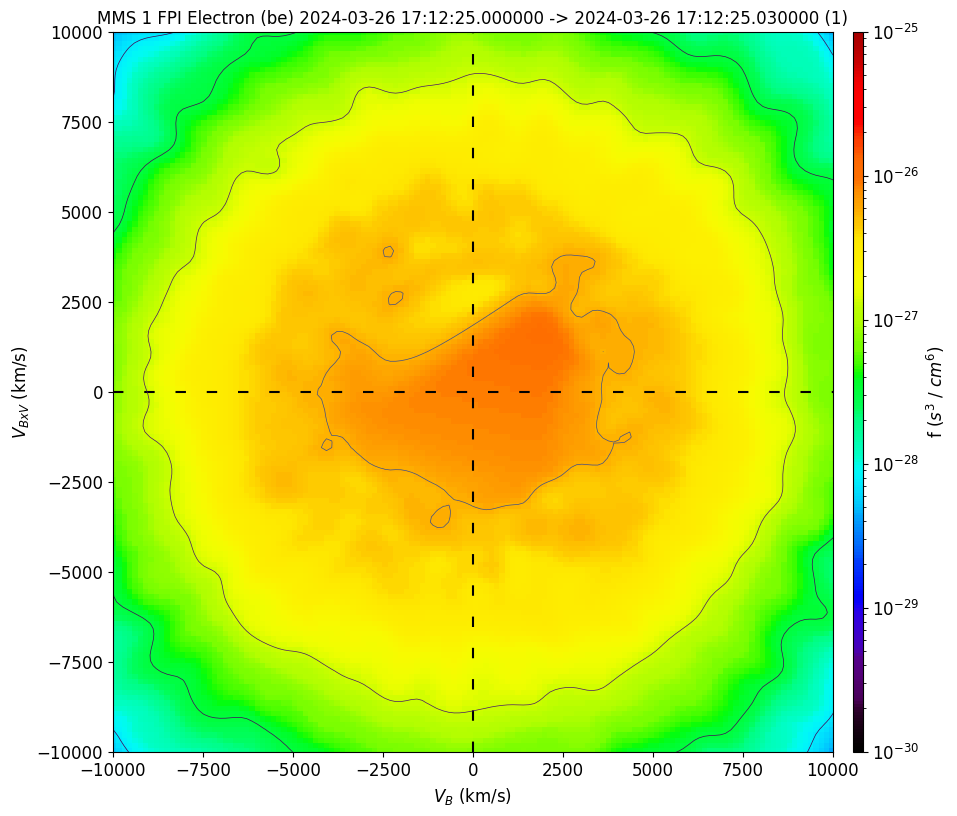

In [ ]:
from pyspedas import mms
from pyspedas.projects.mms.particles import mms_part_slice2d 
from pytplot import get_data, time_double

t0 = '2024-03-26/17:12:25.000'
tf = '2024-03-26/17:12:25.900'
trange = [t0,tf] 
probe = '1'
datarate = 'brst'
FGM=[f'mms{probe}_fgm_b_gse_{datarate}_l2'] 
FPI=[f'mms{probe}_dis_bulkv_gse_{datarate}'] 
DIST = [f'mms{probe}_dis-dist_{datarate}']
MEC=[f'mms{probe}_mec_r_gse']
EDP =[f'mms{probe}_edp_scpot_{datarate}_l2'] 

#MEC DATA
mec_data = mms.mms_load_mec(trange = trange,
               probe = probe,
               varnames=MEC)
Tr, r = get_data(MEC[0])

#SLICE VAR CONFIG
lenght = 0.030
nplots = 1 # nplots = (time_double(trange[1]) - time_double(trange[0]))//dt
Ti = time_double(t0) #+ np.arange(nplots)*dt
olines = 5 #linhas de contorno

for i in range(nplots):
    dist = mms_part_slice2d_mod(time=Ti,
                     samples=nplots,
                     window=lenght,
                     probe=probe,
                     instrument='fpi',
                     data_rate='brst',
                     level='l2',
                     mag_data_rate='brst',
                     rotation='be',
                     species='e',
                     center_time=False,
                     log=False,
                     subtract_bulk=True,
                     erange=[30,20000],
                     xrange=[-10000,10000],
                     yrange=[-10000,10000],
                     zrange=[1e-30,1e-25],
                     resolution=1000,
                     interpolation='2d',
                     contours= olines,
                     title=None,
                     smooth=10,
                     plotsize=10,
                     dpi=500
                     )
    Ti += lenght